In [10]:

import torchvision.transforms as transforms
import torchvision as tv
import torch
import numpy as np
import os


# Нормализация изображений
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])



In [11]:
# Для вывода изображений
import matplotlib.pyplot as plt


In [12]:
# Скачиваем данные, указываем директорию 
trainset = tv.datasets.MNIST(root='./data',  train=True, download=True, transform=transform)
testset = tv.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In [13]:
# Делаем датасеты с различными параметрами
# shuffle -> перемешивать
# num_workers -> сколько процессов обрабатывают
dataloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
# Данные без норализации

#trainset_2 = tv.datasets.MNIST(root='./data_2',  train=True, download=True)
#testset_2 = tv.datasets.MNIST(root='./data_2', train=False, download=True)

In [15]:
#dataloader_2 = torch.utils.data.DataLoader(trainset_2, batch_size=1, shuffle=False, num_workers=4)
#testloader_2 = torch.utils.data.DataLoader(testset_2, batch_size=1, shuffle=False, num_workers=2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


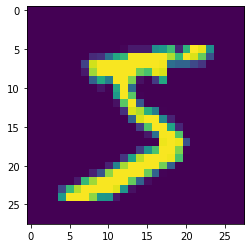

In [16]:
for data in dataloader:

  img, _ = data
  #print(img[0][0])
  plt.imshow(img[0][0])
  break

In [17]:
def plot_image(image):

  image = image[0]
  mean = 0.1307
  std = 0.3081
  image = ((mean * image) + std)
  plt.imshow(image, cmap = 'gray')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


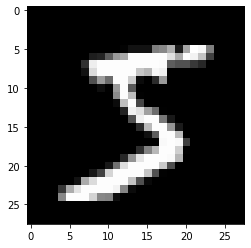

In [18]:
sample_image = next(iter(dataloader))

plot_image(sample_image[0][0])

In [19]:
import torch.nn as nn
import torch.nn.functional as F

In [20]:
## Наследуемся чтобы определить много стандартных методов

"""
MaxPol2D

4x4 -> 2x2

"""

class Net(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 10 , kernel_size = 5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
    self.conv_drop =  nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
     x = self.conv1(x)
     x = F.max_pool2d(x, 2)
     x = F.relu(x)
     x = self.conv2(x)
     x = self.conv_drop(x)
     x = F.max_pool2d(x, 2)
     x = F.relu(x)
     x = x.view(-1, 320)
     x = self.fc1(x)
     x = F.relu(x)
     x = F.dropout(x, training=self.training)
     x = self.fc2(x)
     return F.log_softmax(x)

In [21]:
from torch.autograd import Variable
import matplotlib.pyplot as plt


class Training_Model():

  def __init__(self, model, optimizer_, loss_, is_cuda = False):
    self.model = model
    self.optimizer_ = optimizer_
    self.loss_ = loss_
    self.is_cuda = is_cuda
    self.train_losses = [] 
    self.train_accuracy = []
    self.val_losses = []
    self.val_accuracy = []

    if is_cuda:
      model.cuda()
    else:
      model.cpu() 

  def train_epoch(self, dataloader, phase, volatile=False):
      
      if phase == 'Train':
        self.model.train()
  
      if phase == 'Val':
        # выключаем дропаут
        self.model.eval()
        volatile = True

      running_loss = 0.0
      running_correct = 0.0

      for batch_idx, (data, target) in enumerate(dataloader):
        if self.is_cuda:
          data, target = data.cuda(), target.cuda()

        # Делаем так чтобы были градиенты у них
        data, target = Variable(data, volatile) , Variable(target)
      
        if phase == 'Train':
          self.optimizer_.zero_grad()

        output = self.model(data)
      
        loss = self.loss_(output, target)

        running_loss += self.loss_(output, target, size_average=False)
        
        # ответ сети
        preds = output.data.max(dim=1, keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        
        if phase == 'Train':
          loss.backward()
          self.optimizer_.step()

      loss = running_loss / len(dataloader.dataset)
      accuracy = 100. * running_correct / len(dataloader.dataset)
      print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(dataloader.dataset)} {accuracy:{10}.{4}}')
      return loss, accuracy          


  def print_history_accuracy(self):
    plt.plot(range(1, len(self.train_accuracy) + 1) , self.train_accuracy, 'g', label='train_accuracy')
    plt.plot(range(1, len(self.val_accuracy) + 1) , self.val_accuracy, 'r', label='val_accuracy')
    plt.legend()

  def print_history_loss(self):
    plt.plot(range(1, len(self.train_losses) + 1) , self.train_losses, 'g', label='training_loss')
    plt.plot(range(1, len(self.val_losses) + 1) , self.val_losses, 'r', label='val_losses')
    plt.legend()

  def fit(self, dataloader, testloader,  num_epochs = 5, volatile=False):
    
    self.train_losses, self.train_accuracy = [] , []
    self.val_losses, self.val_accuracy = [] , []
    
    for epoch in range(num_epochs):
      
      print('Epoch [{}/{}]'.format(epoch+ 1, num_epochs))
      epoch_loss, epoch_accuracy = self.train_epoch(dataloader, phase = "Train", volatile=False)
      self.train_losses.append(epoch_loss)
      self.train_accuracy.append(epoch_accuracy)
      
      val_epoch_loss, val_epoch_accuracy = self.train_epoch(testloader, phase = "Val", volatile=False)
      self.val_losses.append(val_epoch_loss)
      self.val_accuracy.append(val_epoch_accuracy)
      print("<---------------------------------->")





In [22]:
import time
import torch.optim

In [23]:

model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
loss = F.nll_loss
TrainModel = Training_Model(model, optimizer, loss, is_cuda = False)

In [24]:
start_time = time.time()
TrainModel.fit(dataloader, testloader, 5)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch [1/5]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated.

Train loss is  0.66 and Train accuracy is 47011.0/60000      78.35
Val loss is  0.13 and Val accuracy is 9611.0/10000      96.11
<---------------------------------->
Epoch [2/5]
Train loss is  0.29 and Train accuracy is 54728.0/60000      91.21
Val loss is 0.086 and Val accuracy is 9737.0/10000      97.37
<---------------------------------->
Epoch [3/5]
Train loss is  0.24 and Train accuracy is 55709.0/60000      92.85
Val loss is 0.073 and Val accuracy is 9763.0/10000      97.63
<---------------------------------->
Epoch [4/5]
Train loss is  0.21 and Train accuracy is 56371.0/60000      93.95
Val loss is 0.063 and Val accuracy is 9804.0/10000      98.04
<---------------------------------->
Epoch [5/5]
Train loss is  0.19 and Train accuracy is 56665.0/60000      94.44
Val loss is 0.059 and Val accuracy is 9813.0/10000      98.13
<---------------------------------->
--- 179.79001712799072 seconds ---


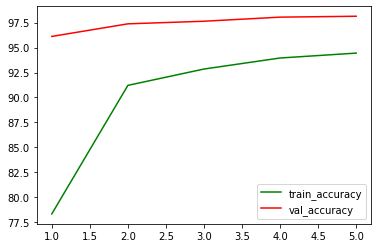

In [25]:
TrainModel.print_history_accuracy()

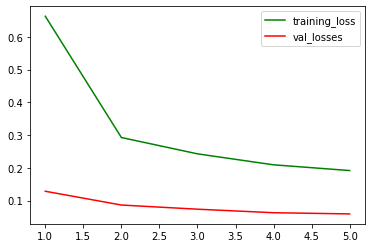

In [26]:
TrainModel.print_history_loss()

In [27]:
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
loss = F.nll_loss
TrainModel = Training_Model(model, optimizer, loss, is_cuda = False)

In [28]:
start_time = time.time()
TrainModel.fit(dataloader, testloader, 5)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch [1/5]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train loss is  0.71 and Train accuracy is 46004.0/60000      76.67
Val loss is  0.16 and Val accuracy is 9508.0/10000      95.08
<---------------------------------->
Epoch [2/5]
Train loss is  0.33 and Train accuracy is 54208.0/60000      90.35
Val loss is  0.11 and Val accuracy is 9646.0/10000      96.46
<---------------------------------->
Epoch [3/5]
Train loss is  0.26 and Train accuracy is 55362.0/60000      92.27
Val loss is 0.083 and Val accuracy is 9725.0/10000      97.25
<---------------------------------->
Epoch [4/5]
Train loss is  0.23 and Train accuracy is 55982.0/60000       93.3
Val loss is 0.075 and Val accuracy is 9752.0/10000      97.52
<---------------------------------->
Epoch [5/5]
Train loss is  0.21 and Train accuracy is 56366.0/60000      93.94
Val loss is 0.063 and Val accuracy is 9788.0/10000      97.88
<---------------------------------->
--- 183.21941113471985 seconds ---


In [29]:
def ind_max(mas):
  maxim = max(mas)
  for i in range(len(mas)):
    if mas[i] == maxim:
      return i

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


3


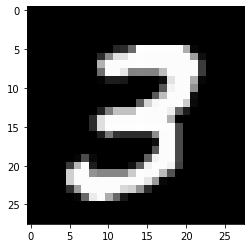

In [31]:
## получаем ответ
sample_image = next(iter(dataloader))
res = model.forward(sample_image[0].cpu())
print(ind_max(res[7]))


plot_image(sample_image[0][7])

In [32]:
#### Save model weights

torch.save(model.state_dict(), "mnist state_dict.pth")


In [33]:
# load model. (weights)

state_dict = torch.load("mnist state_dict.pth", map_location = torch.device ('cpu'))

# model
model_two = Net()

In [34]:
# load weight in my moel
model_two.load_state_dict(state_dict)

<All keys matched successfully>

In [35]:
model_two.eval()


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


3


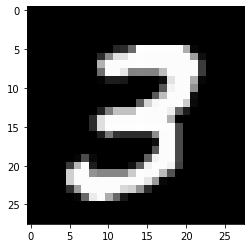

In [36]:
## получаем ответ
sample_image = next(iter(dataloader))
res = model_two.forward(sample_image[0].cpu())
print(ind_max(res[7]))
plot_image(sample_image[0][7])

In [37]:
# Save model onnx
import torch.onnx

model_two.eval()

sample_image = next(iter(dataloader))

dummy_input =  sample_image[0].cpu()

torch_out = model_two(dummy_input)

torch.onnx.export(model_two, dummy_input, "onnx_model_mnist.onnx",opset_version=11) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [38]:
import pip
pip.main(["install", "onnx"])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


0

In [39]:
pip.main(["install", "onnxruntime"])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


0

In [40]:
import onnx
# load onnx model
onnx_model = onnx.load("onnx_model_mnist.onnx")
onnx.checker.check_model(onnx_model)


In [41]:
import onnxruntime
import numpy

ort_session = onnxruntime.InferenceSession("onnx_model_mnist.onnx")

inputs =  dummy_input

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(inputs)}
ort_outs = ort_session.run(None, ort_inputs)

In [42]:
# Смотрим ответ он onnx модели
print(ind_max(ort_outs[0][7]))

#print(ort_outs[0][7])

3
